In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from matplotlib.lines import Line2D

from cryptic_rnn import *

In [140]:
def run_exp(trainseqs_old, trainseqs_old_p, testseqs_old, cue_dict, num_inputs):
    """ assigns integers to symbols and trains RNN on sequence - evaluating on test set on each trial"""
    # assigning value to symbol and calculating trial outputs
    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load train and test trials
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
       
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset,
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def collect_accs(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs):
    """ trains RNNs in parallel and collects r^2 and acc vals"""
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    mods = [r['mod'] for r in res]
    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list = [r['acc'][:,1] for r in res]
    acc_train = np.array(acc_train_list).T
    acc_test = np.array(acc_test_list).T

    mods_p = [r['mod_p'] for r in res]
    acc_train_list_p = [r['acc_p'][:,0] for r in res]
    acc_test_list_p = [r['acc_p'][:,1] for r in res]
    acc_train_p = np.array(acc_train_list_p).T
    acc_test_p = np.array(acc_test_list_p).T
       
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_train_p': acc_train_p[-1,:],\
                          'acc_test': acc_test[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    # fully trained
    fully_trained = acc_df[(acc_df['acc_train'] == 1)&(acc_df['acc_train_p'] == 1)]
    fully_trained_idx = fully_trained.index
    ft_mods = [mods[i] for i in fully_trained_idx]
    print('fully trained models: ',len(ft_mods))
    
    if len(ft_mods) > 0:
        
        ft_tests = [tests[i] for i in fully_trained_idx]
        ft_mods_p = [mods_p[i] for i in fully_trained_idx]

        ft_tests_acc = np.array([acc_test_list[i] for i in fully_trained_idx]).T
        ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
        acc_train = ft_tests_acc[-1,:]
              
        ft_tests_acc_p = np.array([acc_test_list_p[i] for i in fully_trained_idx]).T
        ft_train_acc_p = np.array([acc_train_list_p[i] for i in fully_trained_idx]).T
        acc_train_p = ft_tests_acc_p[-1,:]
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, hidden_size, plot_corr = True)
        plt.title('without primitives; r^2 = ', r2)
        plt.figure()
        r2_p, dfs_p, alldfs = predcorr(ft_mods_p, ft_tests, hidden_size, plot_corr =True)
        plt.title('with primitives; r^2 = ', r2_p)
        
        print('no prims R^2: ', r2, '; acc = ', np.mean(acc_train))
        print('with prims R^2: ', r2_p, '; acc = ', np.mean(acc_train_p))

    else:
        r2, dfs, _ = 0, 0, 0
        r2_p, dfs_p, _ = 0, 0, 0
        
    return {'res':res, 'mods':mods, 'mods_p':mods_p, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df,\
           'dfs':dfs, 'dfs_p':dfs_p, 'r2':r2, 'r2_p':r2_p, 'acc_train':acc_train, 'acc_train_p':acc_train_p}


def MDS_plot(matlist, train_type = 'p', title = ''):
    
    if train_type == 'p':
        cp = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_pos_primitives(all_syms, cue_dict)
    else:
        cp = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
    testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
    valset = [t for t in testseqs if t not in cp]
    valset_idx = [testseqs.index(val) for val in valset]
    print(valset)
    
    colors2 = ['green', 'blue', 'orange', 'red']*4
    colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]
    
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist[1:]):
        mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
        X_transform = mds.fit_transform(dist)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j+1))
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 


In [143]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

# 
xavier_gain = 0.0001

In [144]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
print(primitives)
pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 2, 'B': 14, 'C': 12, 'D': 16}
[['A', '=', 2], ['B', '=', 14], ['C', '=', 12], ['D', '=', 16]]
[[('+', 'A'), '=', 2], [('+', 'B'), '=', 14], [('+', 'C'), '=', 12], [('+', 'D'), '=', 16]]


trainseqs  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 26], [('+', 'C'), ('+', 'A'), '=', 14], [('+', 'D'), ('+', 'A'), '=', 18], [('+', 'C'), ('+', 'B'), '=', 26]]
testseqs  [[('+', 'A'), ('+', 'D'), '=', 18], [('+', 'B'), ('+', 'D'), '=', 30], [('+', 'D'), ('+', 'A'), '=', 18], [('+', 'D'), ('+', 'B'), '=', 30], [('+', 'D'), ('+', 'C'), '=', 28], [('+', 'D'), ('+', 'D'), '=', 32]]
run time:  4.897015802065531
fully trained models:  34
no prims R^2:  0.5926990994758408 ; acc =  0.3480392156862745
with prims R^2:  0.971793843282278 ; acc =  0.6176470588235294


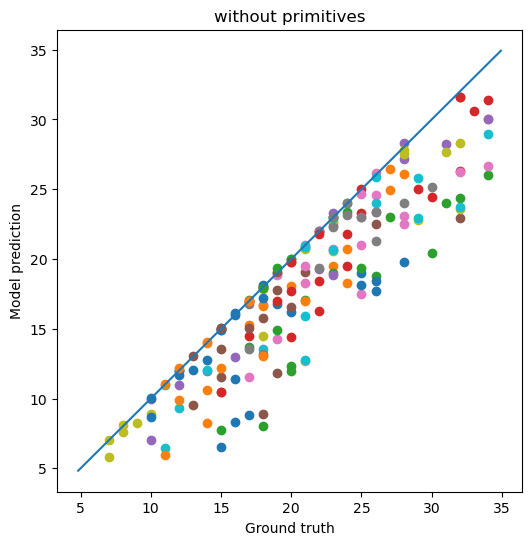

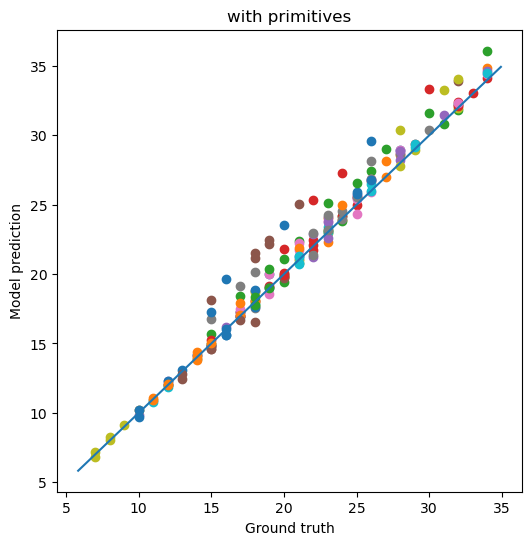

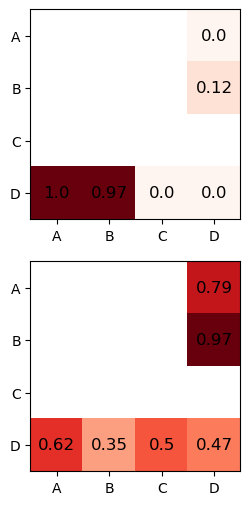

In [147]:
trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
trainseqs_p = generate_pos_other(ops, all_syms[:-1], cue_dict) + pos_primitives
train_all = generate_pos_trials(ops, all_syms[:-1],  all_syms[:-1], cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs if seq not in train_all]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = collect_accs(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs)

fig, ax = plt.subplots(2,1)
heatmap_acc_sign(num_inputs, res1['dfs'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs_p'], ax[1])

In [138]:
res1.keys()

dict_keys(['res', 'mods', 'mods_p', 'tests', 'cue_dicts', 'acc_df', 'dfs', 'dfs_p', 'r2', 'r2_p', 'acc_train', 'acc_train_p'])

no. 100% trained RNNs:  34
[[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 14], [('+', 'A'), ('+', 'D'), '=', 18], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'D'), '=', 30], [('+', 'C'), ('+', 'B'), '=', 26], [('+', 'C'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 28], [('+', 'D'), ('+', 'A'), '=', 18], [('+', 'D'), ('+', 'B'), '=', 30], [('+', 'D'), ('+', 'C'), '=', 28], [('+', 'D'), ('+', 'D'), '=', 32]]


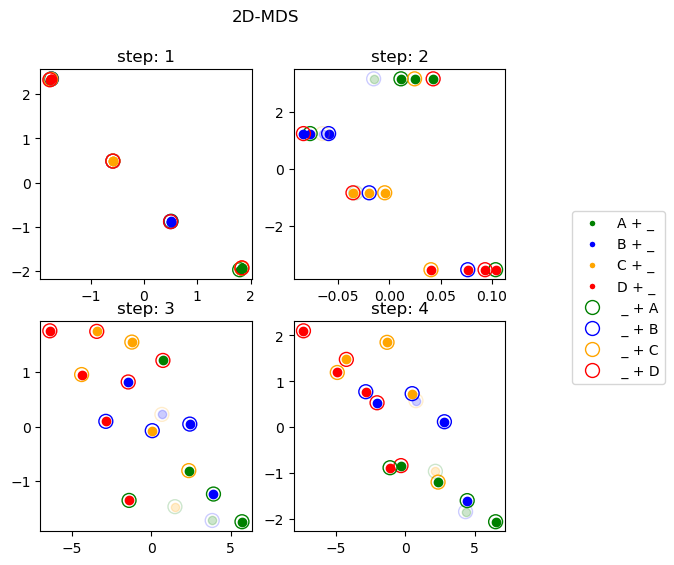

In [148]:
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)

res_rdm = calculate_RDMs(res1, testseqs)

rdms = res_rdm['rdms']
rdms_p = res_rdm['rdms_p']
cue_dicts = res_rdm['ft_cue_dicts']
matlist = [np.array(rdms[t]).mean(axis=0) for t in range(5)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(5)]

MDS_plot(matlist, train_type = 'n', title = '')

[[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 14], [('+', 'A'), ('+', 'D'), '=', 18], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'D'), '=', 30], [('+', 'C'), ('+', 'B'), '=', 26], [('+', 'C'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 28], [('+', 'D'), ('+', 'A'), '=', 18], [('+', 'D'), ('+', 'B'), '=', 30], [('+', 'D'), ('+', 'D'), '=', 32]]


Text(0.5, 0.98, 'without primitives: 2D MDS')

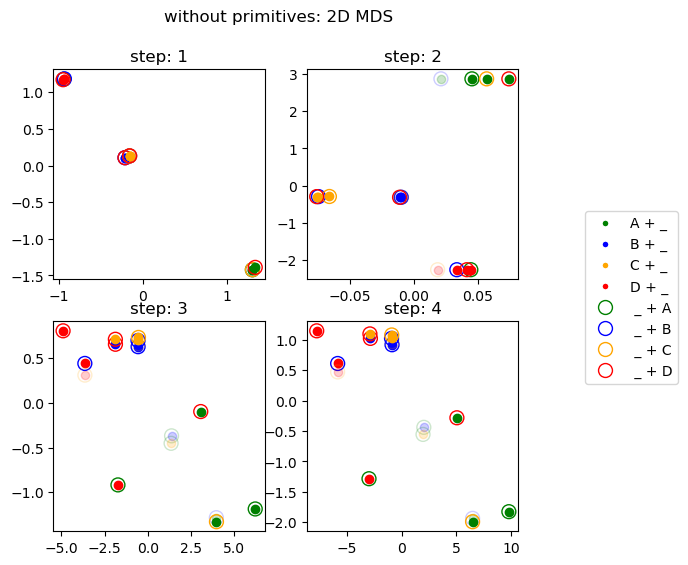

In [151]:
MDS_plot(matlist, train_type = 'n', title = '')
plt.suptitle('without primitives: 2D MDS')

[[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'C'), '=', 14], [('+', 'A'), ('+', 'D'), '=', 18], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 28], [('+', 'B'), ('+', 'D'), '=', 30], [('+', 'C'), ('+', 'B'), '=', 26], [('+', 'C'), ('+', 'C'), '=', 24], [('+', 'C'), ('+', 'D'), '=', 28], [('+', 'D'), ('+', 'A'), '=', 18], [('+', 'D'), ('+', 'B'), '=', 30], [('+', 'D'), ('+', 'C'), '=', 28], [('+', 'D'), ('+', 'D'), '=', 32]]


Text(0.5, 0.98, 'with primitives: 2D MDS')

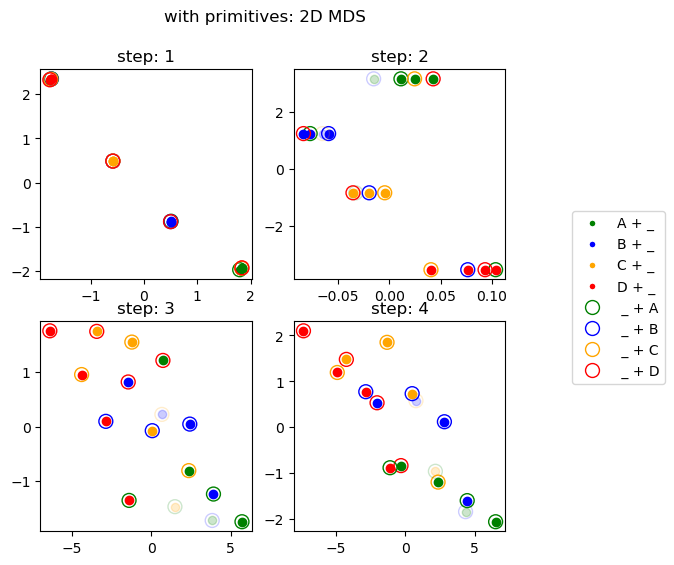

In [152]:
MDS_plot(matlist_p, train_type = 'p', title = '')
plt.suptitle('with primitives: 2D MDS')

variance explained step  0 :    [0.89682808 0.09939023 0.00378169]
variance explained step  1 :    [0.89589579 0.10023122 0.00387299]
variance explained step  2 :    [0.84070237 0.13571503 0.0126013 ]
variance explained step  3 :    [0.83978796 0.13663319 0.01262826]


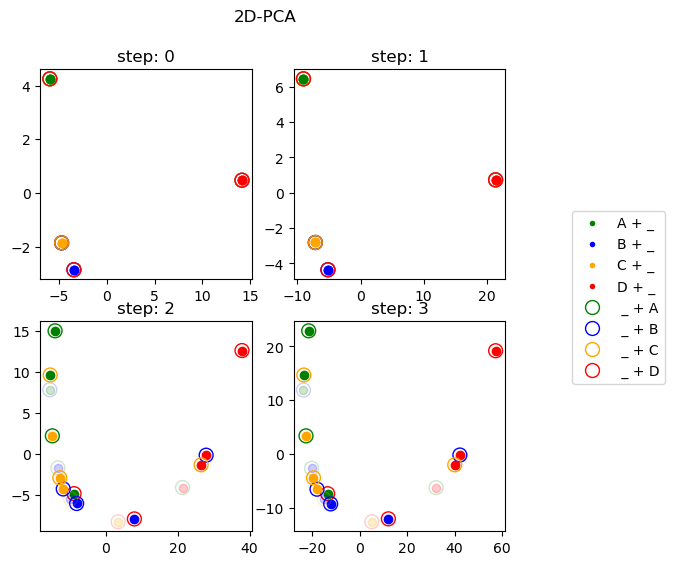

In [130]:
PCA_plot(matlist, train_type = 'n', title = '')

In [153]:
from sklearn.decomposition import PCA
for i in range(1,len(matlist)):
    pca = PCA(n_components=3)
    pca_np = pca.fit(matlist[i])
    print('no prims: step',i,'  ', pca.explained_variance_ratio_)


no prims: step 1    [7.78620021e-01 2.21186940e-01 1.93038690e-04]
no prims: step 2    [7.73352955e-01 2.26512556e-01 1.34488264e-04]
no prims: step 3    [0.75611424 0.21005347 0.01574555]
no prims: step 4    [0.76026249 0.20878471 0.0140035 ]


In [154]:
from sklearn.decomposition import PCA
for i in range(1,len(matlist_p)):
    pca = PCA(n_components=3)
    pca_np = pca.fit(matlist_p[i])
    print('no prims: step',i,'  ', pca.explained_variance_ratio_)


no prims: step 1    [0.82303003 0.15255217 0.0244178 ]
no prims: step 2    [0.82881265 0.14849038 0.02269697]
no prims: step 3    [0.73600834 0.22370222 0.01075279]
no prims: step 4    [0.72692572 0.23873644 0.01198955]


In [116]:
def PCA_plot(matlist, train_type = 'p', title = ''):
    
    if train_type == 'p':
        cp = generate_pos_other(ops, all_syms, cue_dict) + generate_pos_primitives(all_syms, cue_dict)
    else:
        cp = generate_pos_other(ops, all_syms, cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
    testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
    valset = [t for t in testseqs if t not in cp]
    valset_idx = [testseqs.index(val) for val in valset]
    
    colors2 = ['green', 'blue', 'orange', 'red']*4
    colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]
    
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist[1:]):
        pca = PCA(n_components=3)
        X_transform = pca.fit_transform(dist)
        print('variance explained step ', j, ':   ', pca.explained_variance_ratio_)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j))
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

    plt.suptitle('2D-PCA'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 
